# 연습문제_11-3

`penguins` 데이터셋은 이터셋은 남극 Palmer 군도에서 채집된 펭귄들의 신체 특성을 포함하고 있으며, 생태학적 패턴을 이해하는 데 널리 활용된다.

이 데이터셋을 활용하여 펭귄의 주요 연속형 신체 측정값 간의 상관구조를 탐색하고, 부리 특성, 지느러미 및 체중 등 생물학적 특성 간의 관계를 파악하시오.

In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

# 파이썬 기본 패키지:
from itertools import combinations

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

In [3]:
origin = load_data('penguins')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/penguins.xlsx
[desc] 남극 팔머 군도의 펭귄 3종에 대해 신체 치수와 서식지 정보(출처: https://www.kaggle.com/datasets/larsen0966/penguins)

field              description
-----------------  -------------
species            팽귄 종
island             서식지
bill_length_mm     부리 길이
bill_depth_mm      부리 두께
flipper_length_mm  날개 길이
body_mass_g        몸무게
sex                성별


===== 데이터 크기 확인 =====
데이터셋 크기: (334, 7)
열 갯수: 7
행 갯수: 334

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   bill_length_mm     334 non-null    float64
 3   bill_depth_mm      334 non-null    float64
 4   flipper_length_mm  334 non-null    int64  
 5   body_mass_g        334 non-null    int64  
 6   sex                333 non-null    object 

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE


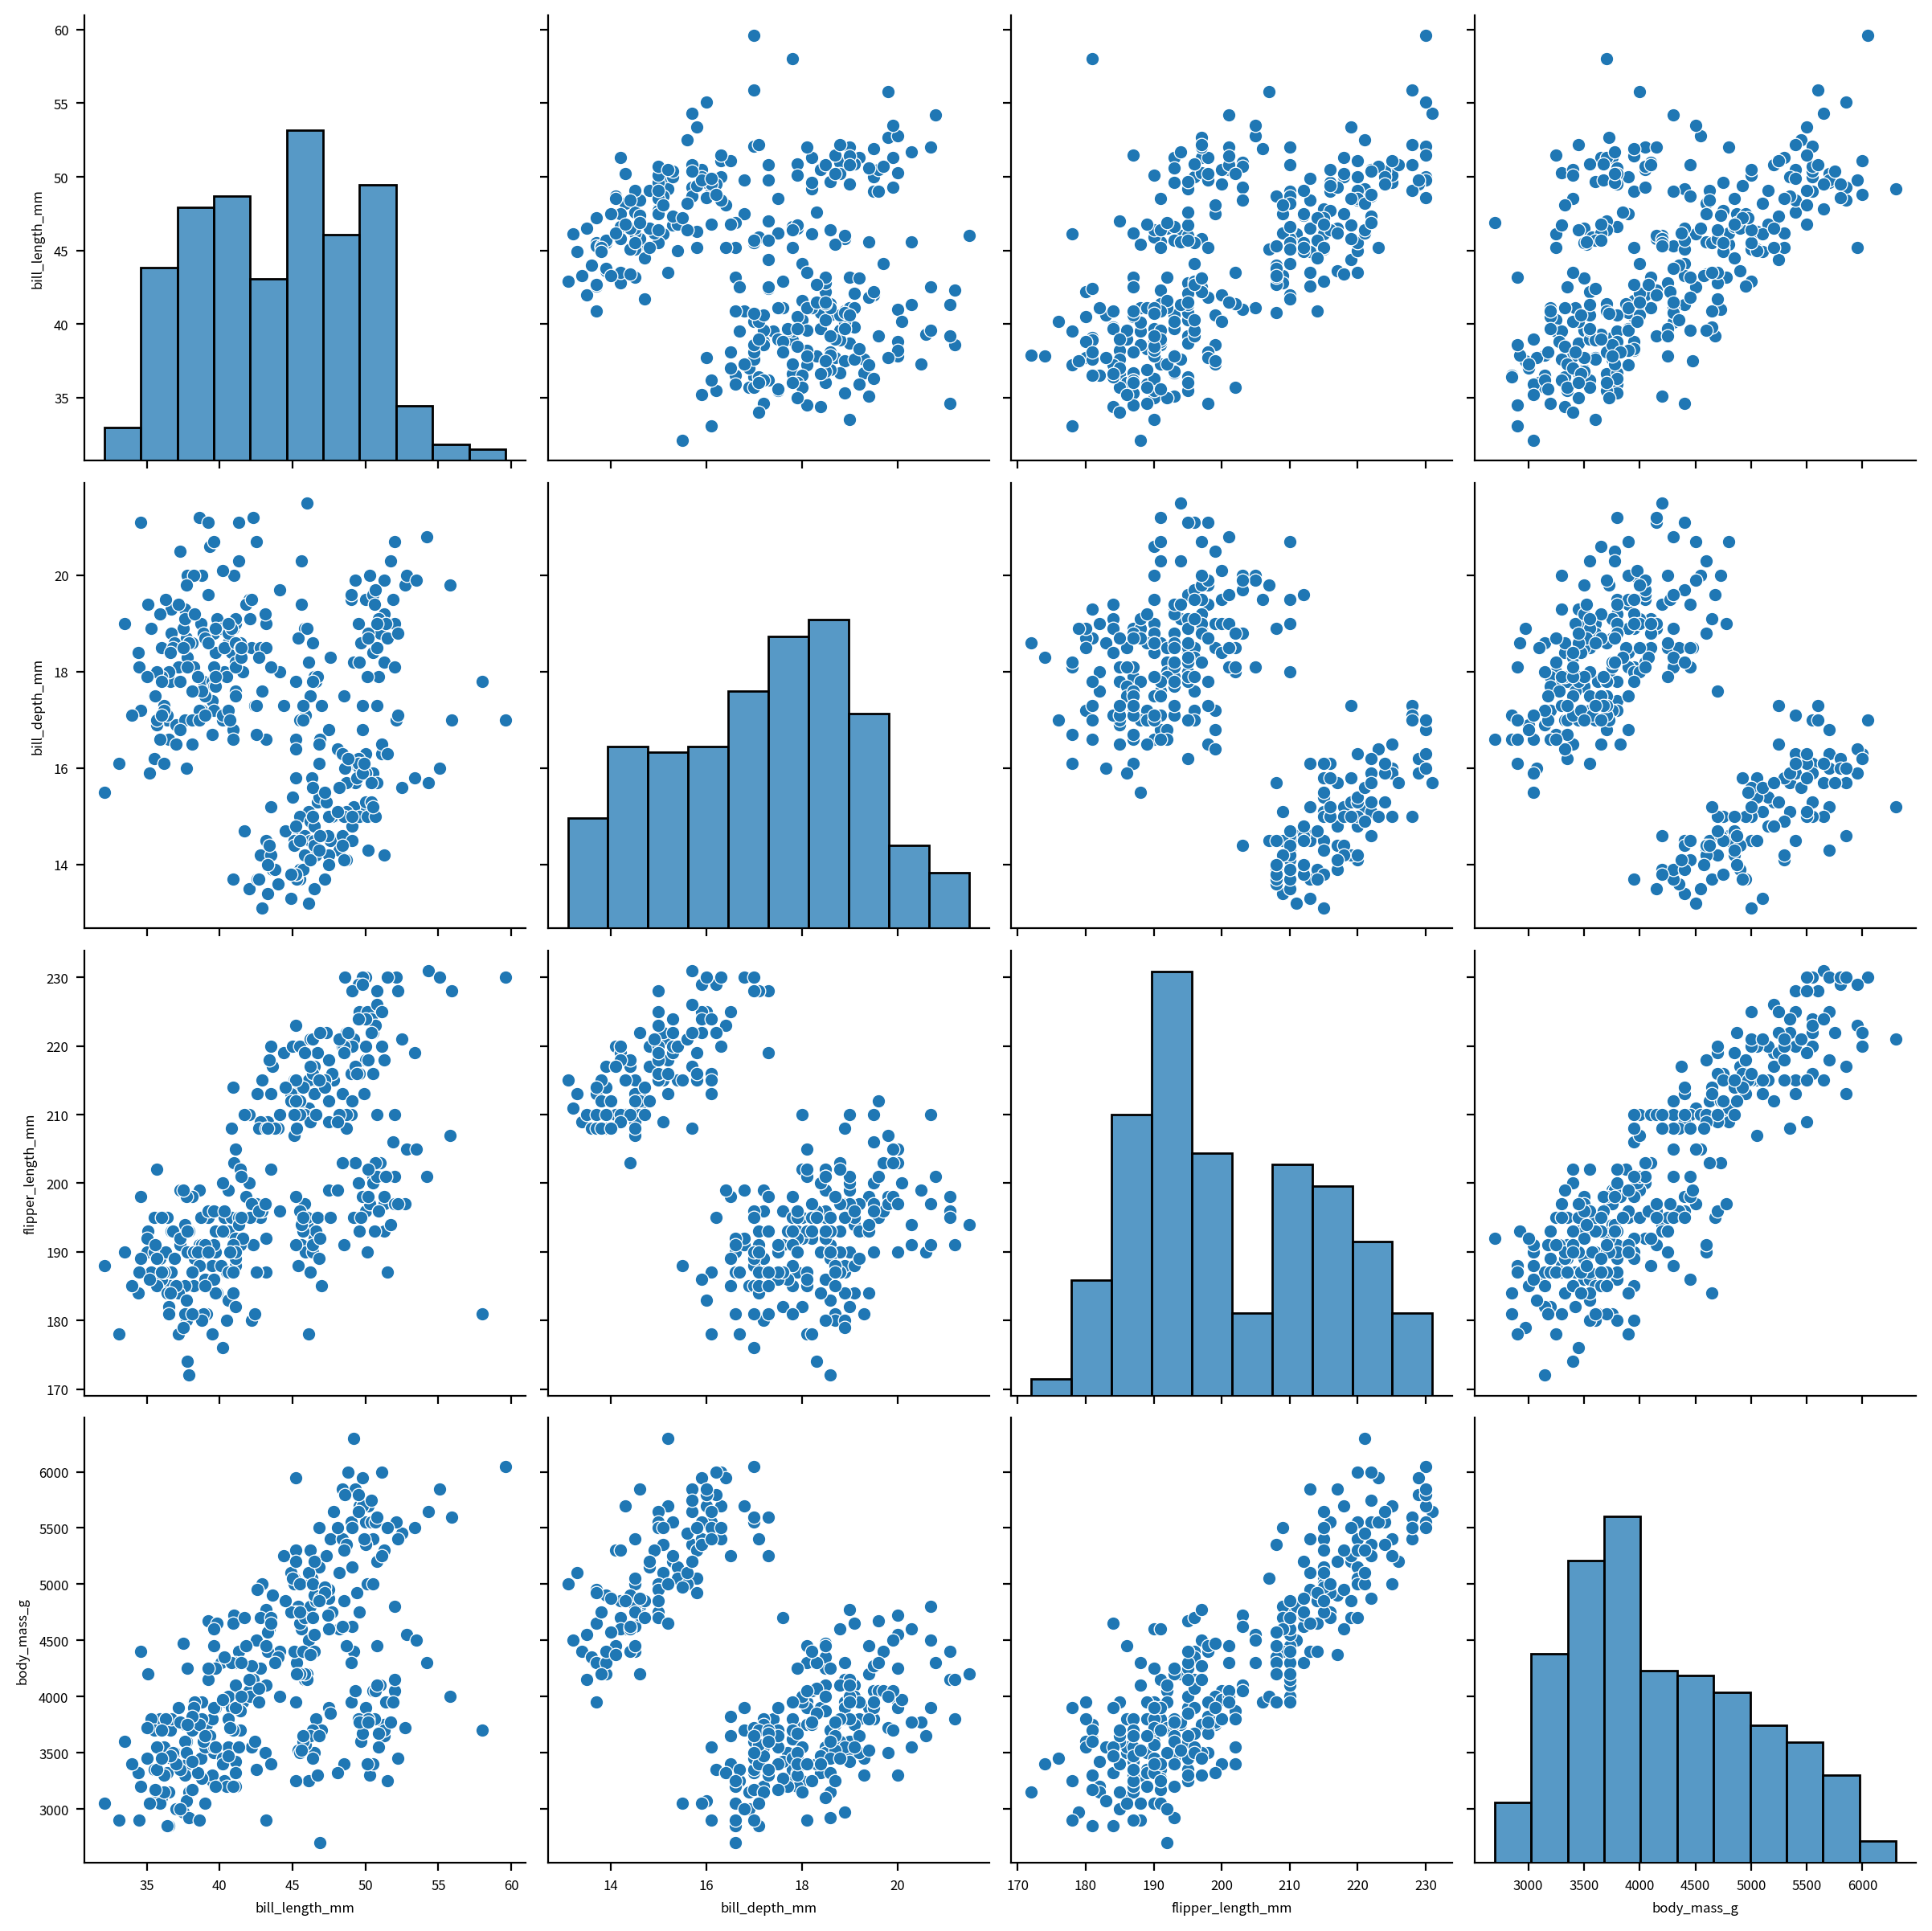

In [4]:
# 데이터 전처리: 수치형 변수 컬럼들만 필터
df = origin.filter(['bill_length_mm', 'bill_depth_mm', 
                    'flipper_length_mm', 'body_mass_g'])

# 1) 그래프 초기화
width_px = 2400             # width_px = height_px
height_px = 2400             
figsize = (width_px / my_dpi, height_px / my_dpi)

# 2) Pair Plot 그래프 그리기
g = sb.pairplot(df, diag_kind='hist')
g.fig.set_dpi(my_dpi)
g.fig.set_size_inches(figsize)

# 3) 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프 화면 출력
plt.close()                 # 그래프 작업 종료

In [5]:
skew_outlier = {}

for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }

skew_outlier_df = pd.DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z| > 3)
bill_length_mm,0.050796,-0.765943,0.0
bill_depth_mm,-0.155316,-0.732511,0.0
flipper_length_mm,0.359305,-0.791583,0.0
body_mass_g,0.471045,-2.611903,0.0


In [6]:
rows = []

for a, b in combinations(df.columns, 2):
    x = df[a]
    y = df[b]

    # [1] 선형성 확인 (Ramsey RESET):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power = 2, use_f = True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부(|z| > 3 기준):
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산:
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)
    
    # [4] 유의성 판단 (p <= 0.05):
    significant = pval <= 0.05

    # [5] 상관강도 계산:
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    # [6] 행 추가:
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,bill_length_mm,bill_depth_mm,False,False,spearman,-0.216209,6.782928e-05,True,Weak
1,bill_length_mm,flipper_length_mm,False,False,spearman,0.671510,3.901395e-45,True,Strong
2,bill_length_mm,body_mass_g,False,False,spearman,0.579194,2.591284e-31,True,Medium
3,bill_depth_mm,flipper_length_mm,False,False,spearman,-0.518341,2.317525e-24,True,Medium
4,bill_depth_mm,body_mass_g,False,False,spearman,-0.430729,1.609964e-16,True,Medium
5,flipper_length_mm,body_mass_g,False,False,spearman,0.841582,8.031883e-91,True,Very strong


In [7]:
# 1) 등장하는 모든 변수 목록 추출:
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))
             # ↑: 중복 제거하고 추출

# 2) 빈 상관행렬 생성 (NaN으로 초기화):
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭행렬 채우기:
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r   # 대칭 

# 4) 대각선(diagonal)을 1로 설정:
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,bill_depth_mm,bill_length_mm,body_mass_g,flipper_length_mm
bill_depth_mm,1.000000,-0.216209,-0.430729,-0.518341
bill_length_mm,-0.216209,1.000000,0.579194,0.671510
body_mass_g,-0.430729,0.579194,1.000000,0.841582
flipper_length_mm,-0.518341,0.671510,0.841582,1.000000


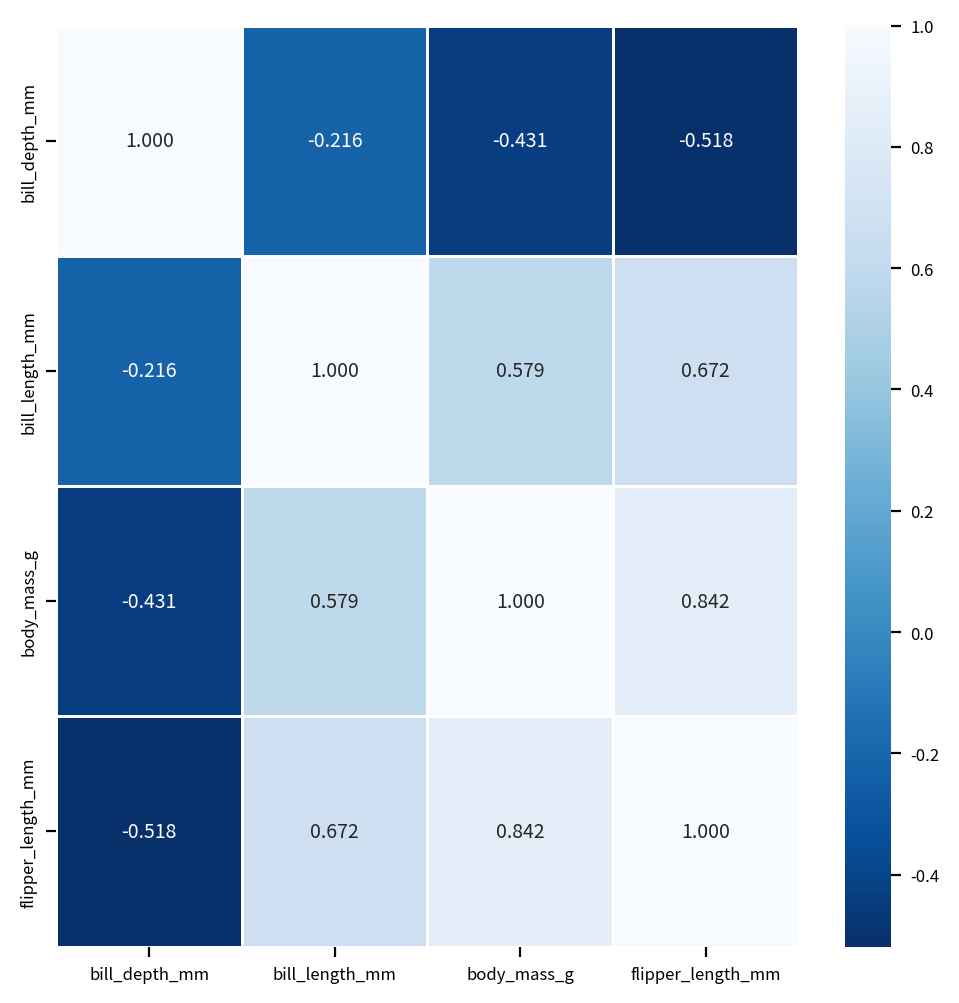

In [11]:
# 1) 그래프 초기화
width_px = 1000              # 그래프 가로크기
height_px = 1000             # 그래프 세로크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)


# 2) Heatmap 그리기: seaborn 사용
sb.heatmap(data = corr_matrix, annot=True, fmt='0.3f', 
           linewidth = 0.5, cmap = "Blues_r", 
           annot_kws = {'size': 7})
  # camp: 칼라맵 종류: 'Greys', 'Purples', 'Blues', 'Greens', 
  # 'Oranges', 'Reds' / 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
  # 'RdPu', 'BuPu' / 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 
  # 'BuGn', 'YlGn' / 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 
  # 'RdBu', 'RdYlBu' / 'RdYlGn', 'Spectral', 'coolwarm', 
  # 'bwr', 'seismic' / 'berlin', 'managua', 'vanimo'


# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료